In [4]:
import sys
sys.path.append('../')

In [202]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

# SSMs

In [ ]:
class SSM(torch.nn.Module):

    def __init__(self, ni, no, nsv):
        super().__init__()
        self.ni = ni
        self.no = no
        self.nsv = nsv
        self.A = torch.nn.Linear(nsv, nsv)
        self.B = torch.nn.Linear(ni, nsv)
        self.C = torch.nn.Linear(nsv, no)
        # self.A = torch.randn([nsv, nsv])
        # self.B = torch.randn([ni, nsv])
        # self.C = torch.randn([nsv, no])
    

    def forward(self, u, x0 = None):
        """
            - u: BATCH x LEN_OF_TS x NUM_OF_INPUTS
            - x: BATCH x NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((u.shape[0], self.nsv))
        else:
            x = x0
        ut = torch.transpose(u, 0, 1)
        y = torch.zeros([ut.shape[0], ut.shape[1], self.no])
        x_hist = torch.zeros([u.shape[1], u.shape[0], self.nsv])
        for (i, u_i) in enumerate(ut):
            y[i] += self.C(x)
            x = self.A(x) +self.B(u_i)
            x_hist[i] += x
        return torch.transpose(y, 0, 1), torch.transpose(x_hist, 0, 1)


In [ ]:
class SSM(torch.nn.Module):

    def __init__(self, ni, no, nsv):
        super().__init__()
        self.ni = ni
        self.no = no
        self.nsv = nsv
        self.A = torch.randn([nsv, nsv], requires_grad=True)
        self.B = torch.randn([nsv, ni], requires_grad=True)
        self.C = torch.randn([no, nsv], requires_grad=True)
    

    def forward(self, u, x0 = None):
        """
            - u: LEN_OF_TS x NUM_OF_INPUTS
            - x: NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((self.nsv))
        else:
            x = x0
        y = torch.zeros([u.shape[0], self.no])
        x_hist = torch.zeros([u.shape[0], self.nsv])
        for (i, u_i) in enumerate(u):
            y[i] += self.C @ x
            x = self.A @ x +self.B @ u_i
            x_hist[i] += x
        return y, x_hist


In [131]:
class SSM(torch.nn.Module):
    

    def __init__(self, A, B, C):
        super().__init__()

        wA = A
        wB = B
        wC = C
        self.ni = wB.shape[1]
        self.no = wC.shape[0]
        self.nsv = wA.shape[0]
        self.A = torch.nn.Parameter(A)
        self.B = torch.nn.Parameter(B)
        self.C = torch.nn.Parameter(C)
    

    @staticmethod
    def auto_init(ni, no, nsv):
        A = torch.randn([nsv, nsv], requires_grad=True)
        B = torch.randn([nsv, ni], requires_grad=True)
        C = torch.randn([no, nsv], requires_grad=True)
        return SSM(A, B, C)
        

    def forward(self, u, x0 = None):
        """
            - u: LEN_OF_TS x NUM_OF_INPUTS
            - x: NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((self.nsv))
        else:
            x = x0
        y = torch.zeros([u.shape[0], self.no])
        x_hist = torch.zeros([u.shape[0], self.nsv])
        for (i, u_i) in enumerate(u):
            y[i] += self.C @ x
            x = self.A @ x +self.B @ u_i
            x_hist[i] += x
        return y, x_hist


# Gen data

In [255]:
NSV = 5
NI = 3
NO = 2
TS_LENGTH = 10
GS = max([NSV, NI, NO])


In [256]:
X0 = torch.zeros([NSV])

In [257]:
U = torch.tensor([[
    i > 5, (i > 5) or (i < 10), (i > 5) or (i < 10) or (i > 15) 
] for i in range(TS_LENGTH)], dtype=torch.float32)

In [258]:
M = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
with torch.no_grad():
    Y, _ = M(U, X0)
LOSS = torch.nn.MSELoss()


In [259]:
m = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
p, _ = m(U, X0)
l = LOSS(p, Y)
l.backward()
print(l)

tensor(902828.8125, grad_fn=<MseLossBackward0>)


In [276]:
m = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
step_size = 0.000003
for i in range(10):
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    print(l)
    gA = m.A.grad
    gB = m.B.grad
    gC = m.C.grad
    m.A.data -= step_size * gA
    m.B.data -= step_size * gB
    m.C.data -= step_size * gC
p, _ = m(U, X0)
l = LOSS(p, Y)
print(l)

tensor(23291.4336, grad_fn=<MseLossBackward0>)
tensor(21646.3184, grad_fn=<MseLossBackward0>)
tensor(21216.1836, grad_fn=<MseLossBackward0>)
tensor(20386.0352, grad_fn=<MseLossBackward0>)
tensor(17604.8477, grad_fn=<MseLossBackward0>)
tensor(17824.3477, grad_fn=<MseLossBackward0>)
tensor(14297.5234, grad_fn=<MseLossBackward0>)
tensor(14283.0547, grad_fn=<MseLossBackward0>)
tensor(10020.8184, grad_fn=<MseLossBackward0>)
tensor(8626.4131, grad_fn=<MseLossBackward0>)
tensor(10294.7637, grad_fn=<MseLossBackward0>)


In [289]:
def pad_grad(g):
    return torch.nn.functional.pad(g.squeeze(0), [0, abs(g.shape[1] - GS), 0, abs(g.shape[0] - GS)], )

def get_ssm_from_v(u):
    slice1 = NSV * NSV
    slice2 = slice1 + NSV * NI
    slice3 = slice2 + NSV * NO
    A = u[:slice1].reshape(NSV, NSV)
    B = u[GS:][slice1:slice2].reshape(NSV, NI)
    C = u[2*GS:][slice2:slice3].reshape(NO, NSV)
    m = SSM(A, B, C)
    return m

def F_ex_grad(u):
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    gAp = pad_grad(m.A.grad)
    gBp = pad_grad(m.B.grad)
    gCp = pad_grad(m.C.grad)
    return np.concat([gAp.reshape(-1), gBp.reshape(-1), gCp.reshape(-1)])


def F_ex_mse(u):
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    return l.detach()


def project(x):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x


def P_ex1(u):
    return project(u)

    

In [290]:
sp = torch.rand([GS * GS * 3])
u_ex = torch.rand([GS * GS * 3])

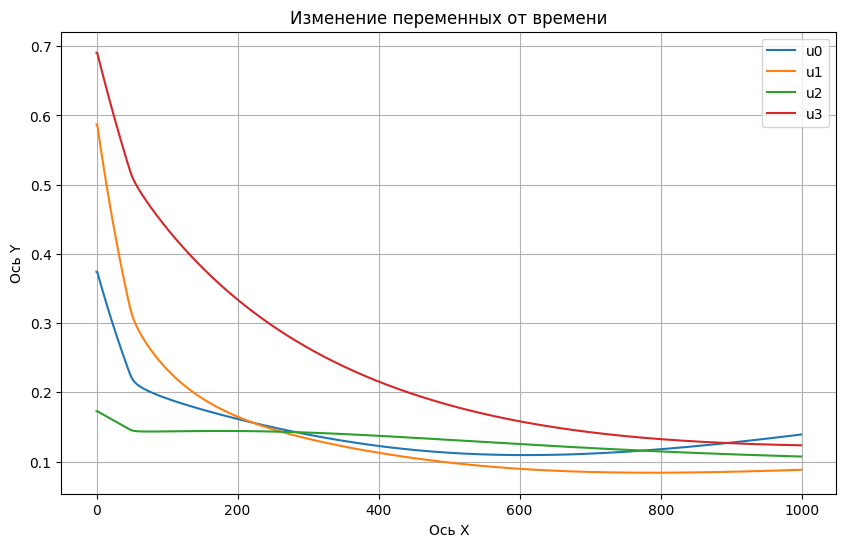

tensor(29381.5664, grad_fn=<MseLossBackward0>)


In [291]:
F_1 = Adapter(F_ex_grad)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, sp, P = P_1)
answer, verbose = Ex_solver.solve(u_ex)
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 

plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()
m = get_ssm_from_v(answer)
p, _ = m(U, X0)
print(LOSS(p, Y))

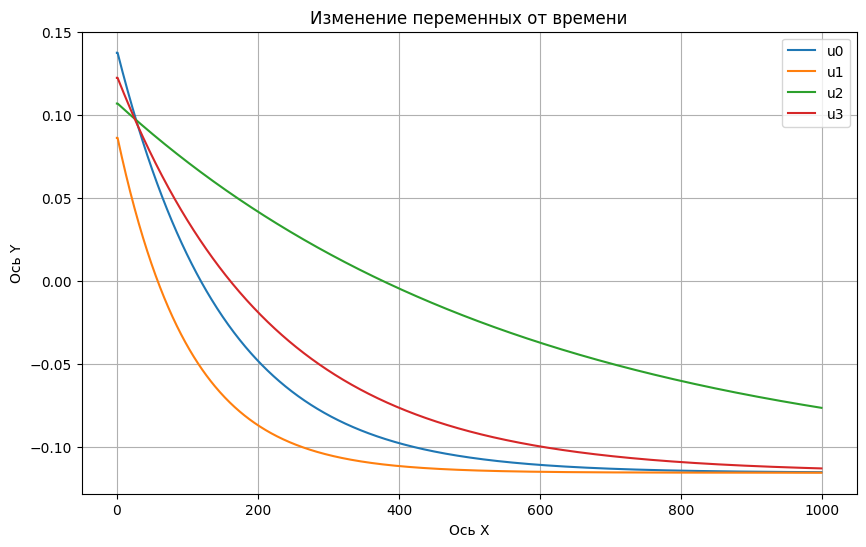

tensor(29544.0996, grad_fn=<MseLossBackward0>)


In [292]:
F_1 = Adapter(F_ex_mse)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, sp, P = P_1)
answer, verbose = Ex_solver.solve(u_ex)
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 

plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()
m = get_ssm_from_v(answer)
p, _ = m(U, X0)
print(LOSS(p, Y))